#**Time Series Forcasting using LSTM and AutoRegressive Model**






In [ ]:

# this is the link which will download the data
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-04-19 21:22:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-04-19 21:22:26 (33.1 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



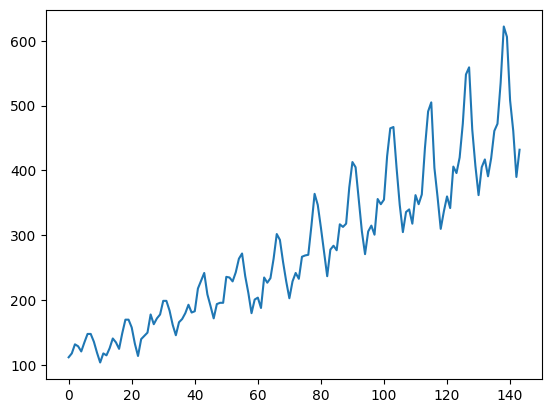

Epoch: 0, loss: 0.54074
Epoch: 100, loss: 0.01942
Epoch: 200, loss: 0.01465
Epoch: 300, loss: 0.00406
Epoch: 400, loss: 0.00368
Epoch: 500, loss: 0.00332
Epoch: 600, loss: 0.00293
Epoch: 700, loss: 0.00258
Epoch: 800, loss: 0.00233
Epoch: 900, loss: 0.00212
Epoch: 1000, loss: 0.00194
Epoch: 1100, loss: 0.00180
Epoch: 1200, loss: 0.00171
Epoch: 1300, loss: 0.00168
Epoch: 1400, loss: 0.00166
Epoch: 1500, loss: 0.00165
Epoch: 1600, loss: 0.00165
Epoch: 1700, loss: 0.00164
Epoch: 1800, loss: 0.00163
Epoch: 1900, loss: 0.00163


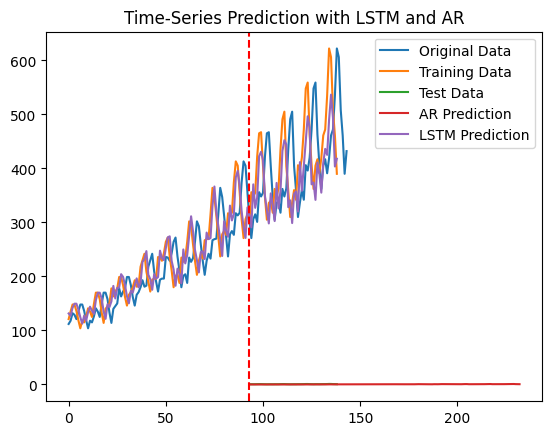

LSTM - MSE: 2651.49, RMSE: 51.49, MAE: 42.14
AR - MSE: 11539.25, RMSE: 107.42, MAE: 88.33


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare the data
training_set = pd.read_csv('airline-passengers.csv')
training_set = training_set.iloc[:, 1:2].values

# Plot the data
plt.plot(training_set, label='Airline Passengers Data')
plt.show()

# Define a sliding window function
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

# Prepare the data for training the LSTM model
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

# Set the hyperparameters for the LSTM model
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

# Create the LSTM model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Define the loss function and optimizer for training the LSTM model
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the LSTM model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # Obtain the loss function
    loss = criterion(outputs, trainY)

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

# Train the AR model

from statsmodels.tsa.ar_model import AutoReg
ar_order = 4 # order of AR model
ar_model = AutoReg(training_data, lags=ar_order)
ar_results = ar_model.fit()

# Make predictions with LSTM model
# -----------------------------------------
lstm.eval()
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# Make predictions with AR model
ar_predict = ar_results.predict(start=ar_order, end=len(training_data)-1)
# Plot results
plt.plot(training_set, label='Original Data')
plt.plot(dataY_plot, label='Training Data')
plt.plot(train_size+np.arange(len(testY)), testY, label='Test Data')
plt.plot(train_size+np.arange(len(ar_predict)), ar_predict, label='AR Prediction')
plt.plot(data_predict, label='LSTM Prediction')
plt.axvline(x=train_size, c='r', linestyle='--')
# plt.legend()
plt.title('Time-Series Prediction with LSTM and AR')
plt.legend()
plt.show()

ar_model = AutoReg(training_set, lags=seq_length, trend='c')
ar_model_fit = ar_model.fit()

# Make predictions on the test data using the trained AR model

ar_predict = ar_model_fit.predict(start=train_size, end=train_size+test_size-1, dynamic=False)

# Calculate the evaluation metrics for both models

lstm_mse = mean_squared_error(dataY_plot[train_size:], data_predict[train_size:])
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(dataY_plot[train_size:], data_predict[train_size:])

ar_mse = mean_squared_error(dataY_plot[train_size:], ar_predict)
ar_rmse = np.sqrt(ar_mse)
ar_mae = mean_absolute_error(dataY_plot[train_size:], ar_predict)

# Print the evaluation metrics for both models

print("LSTM - MSE: %0.2f, RMSE: %0.2f, MAE: %0.2f" % (lstm_mse, lstm_rmse, lstm_mae))
print("AR - MSE: %0.2f, RMSE: %0.2f, MAE: %0.2f" % (ar_mse, ar_rmse, ar_mae))



